In [4]:
import numpy as np
from music21 import *
import glob
import sys
import math
from tensorflow.keras.models import Sequential, Model, load_model
sys.path.append("../RL modules/")
from env_noOctave import SegmentationEnv
import matplotlib.pyplot as plt

In [3]:
base_lr = 0.001
max_lr = 0.1
step_size = 8
def masterScheduler(epoch):
    def scheduler():
            period = 2 * step_size
            cycle = math.floor(1 + epoch/period)
            x = abs(epoch/step_size - 2*cycle + 1)
            delta = (max_lr - base_lr)*max(0, (1 - x))
            delta /= float(2 ** (cycle - 1))
            return base_lr + delta
    return scheduler

Text(0.5, 1.0, 'LR schedule')

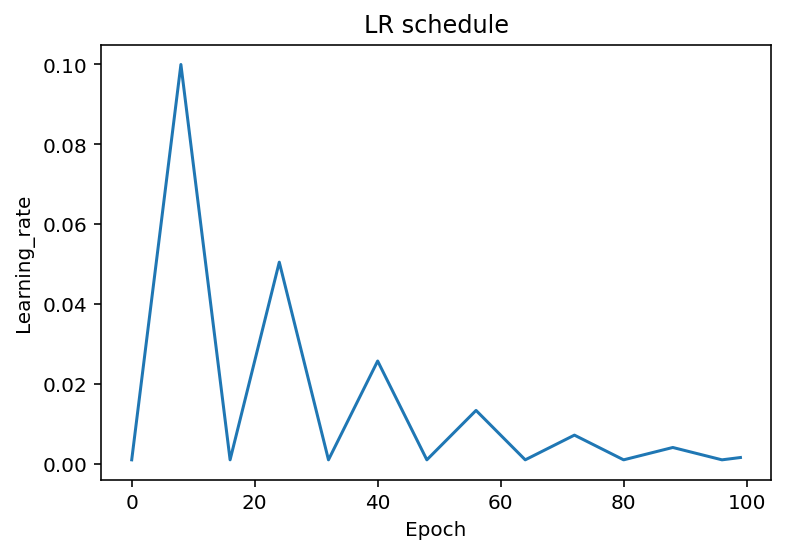

In [7]:
lr_schedule = []
for i in range(100):
    lr_schedule.append(masterScheduler(i)())
plt.plot(lr_schedule)
plt.xlabel("Epoch")
plt.ylabel("Learning_rate")
plt.title("LR schedule")

In [8]:
testing_pieces = []
for piece in glob.glob('./normal/testing/*'):
    testing_pieces.append(piece)

# for piece in glob.glob('./C_normalized/testing/*'):
#     testing_pieces.append(piece)

In [17]:
testing_pieces 

['./normal/testing\\Debussy_Arabesque_No._1_in_E_Major.musicxml',
 './normal/testing\\Il_Vecchio_Castello.mxl',
 './normal/testing\\not1_Prelude_I.musicxml',
 './normal/testing\\Piano_Sonata_No._11.mxl',
 './normal/testing\\Prélude_in_C_Minor.mxl',
 './normal/testing\\Waltz_in_A_Minor.mxl',
 './normal/testing\\Étude_in_C_Minor.mxl']

In [10]:
model = load_model("dqn_lstm_normalized")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 26)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               79360     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 87,746
Trainable params: 87,746
Non-trainable params: 0
_________________________________________________________________


In [ ]:
env = SegmentationEnv(testing_pieces)

start
change key
change key
change key
change key
change key
change key
change key
change key
change key
change key
change key
change key
./normal/testing\Debussy_Arabesque_No._1_in_E_Major.musicxml
start
change key
change key
change key
change key
change key
change key
change key
change key
change key
change key
change key
change key
./normal/testing\Il_Vecchio_Castello.mxl
start
change key
Error in piece ./normal/testing\not1_Prelude_I.musicxml 'x\nC'
start
change key
change key
change key
change key
change key
change key
change key
change key
change key
change key
./normal/testing\Piano_Sonata_No._11.mxl
start
./normal/testing\Prélude_in_C_Minor.mxl
start
change key
change key
change key
change key
change key
change key
./normal/testing\Waltz_in_A_Minor.mxl
start
change key
change key
change key
change key
change key
change key
change key
change key
./normal/testing\Étude_in_C_Minor.mxl
Total number of pieces 6


In [14]:
def Visualization(piece,offset): #offset assume sorted.
    def cal_offset(e):
        if e is None:
            return 0
        return e.offset + cal_offset(e.activeSite)
    c = converter.parse(piece)
    # partStream = c.parts.stream()
    # post = c.flattenParts().flat
    all_notes = []
    # for note in post.notes:
    #     print(note,note.offset,note.lyric)
    for el in c.recurse().notes:
        if el.lyric is not None:
            el.lyric = el.lyric.replace("♭", "b")
        all_notes.append([el.lyric, el, cal_offset(el),el.duration.linked])
    b = sorted(all_notes, key=lambda x: x[0] if x[0] is not None else "ZZZ")
    b = sorted(b, key=lambda x: x[-2])
    # print(b)
    for e in b:
        if len(offset) >0 and float(round(e[2],1)) >= offset[0] and e[3]:
            del offset[0]
            e[1].addLyric("CUT")
    GEX = musicxml.m21ToXml.GeneralObjectExporter(c)
    out = GEX.parse()
    piecename = piece.split("\\")[-1]
    piecename = piecename.split(".")[0]
    piecename = "LSTMVis_"+piecename + ".musicxml"
    print(piece,piecename)
    with open(piecename, "wb") as f:
        f.write(out)

In [21]:
###NORMAL VERSION
for i in range(len(env.notes)):
    offsets = []
    obs = env.reset(i)
    total_reward = 0
    max_reward = 0
    num_correct_segment = 0
    while True:
        obs = obs.reshape((1, 12*2+1))
        action = np.argmax(model.predict(obs))
        if action == 1:
            offsets.append(env.current_noteoffset)
        obs, reward, done, info = env.step(action)
        #env.render()
        total_reward += reward
        max_reward += 1
        if reward ==1 and action == 1:
            num_correct_segment += 1
        if done:
            break
    print(f"Piece {testing_pieces[i]}, total reward = {total_reward}/{max_reward}, correct segment = {num_correct_segment}")
    offsets = [float(round(offset,1)) for offset in offsets]
    print(offsets)
    try:
        Visualization(env.piecelist[i],offsets)
    except:
        print("ERROR IN PIECE.")

Piece ./normal/testing\Debussy_Arabesque_No._1_in_E_Major.musicxml, total reward = 156/410, correct segment = 85
[4.0, 9.0, 10.0, 11.0, 21.0, 25.0, 26.0, 31.0, 33.0, 34.0, 38.0, 40.0, 44.0, 46.0, 47.0, 66.0, 68.0, 70.0, 72.0, 74.0, 76.0, 79.0, 83.0, 84.0, 86.0, 89.0, 91.0, 94.0, 96.0, 100.0, 108.0, 110.0, 112.0, 113.0, 114.0, 120.0, 126.0, 127.0, 134.0, 137.0, 139.0, 140.0, 144.0, 145.0, 152.0, 155.0, 156.0, 165.0, 166.0, 168.0, 169.0, 172.0, 173.0, 176.0, 177.0, 179.0, 180.0, 184.0, 188.0, 191.0, 196.0, 199.0, 201.0, 205.0, 207.0, 219.0, 220.0, 222.0, 223.0, 228.0, 232.0, 233.0, 236.0, 237.0, 240.0, 241.0, 243.0, 244.0, 248.0, 249.0, 251.0, 252.0, 253.0, 255.0, 256.0, 258.0, 259.0, 264.0, 266.0, 268.0, 270.0, 272.0, 276.0, 277.0, 280.0, 282.0, 284.0, 286.0, 288.0, 290.0, 291.0, 301.0, 305.0, 306.0, 311.0, 313.0, 314.0, 318.0, 320.0, 324.0, 326.0, 327.0, 346.0, 348.0, 350.0, 352.0, 354.0, 356.0, 358.0, 359.0, 360.0, 362.0, 364.0, 366.0, 367.0, 368.0, 369.0, 372.0, 373.0, 382.0, 386.0, 

In [ ]:
###LSTM Version
for i in range(len(env.notes)):
    offsets = []
    obs = env.reset(i)
    total_reward = 0
    max_reward = 0
    num_correct_segment = 0
    state_data = []
    for j in range(10 - 1):
        state_data.append(np.append(np.zeros((12 * 2 + 1,)), -1))
    state_data.append(np.append(obs, -1))
    while True:
        state_datax = np.array(state_data)
        state_datax = state_datax.reshape((1, 10, 2 * 12 + 1 + 1))
        action = np.argmax(model.predict(state_datax))
        if action == 1:
            offsets.append(env.current_noteoffset)
        obs, reward, done, info = env.step(action)
        #env.render()
        del state_data[0]
        state_data[-1][-1] = action
        state_data.append(np.append(obs, -1))
        total_reward += reward
        max_reward += 1
        if reward ==1 and action == 1:
            num_correct_segment += 1
        if done:
            break
    print(f"Piece {testing_pieces[i]}, total reward = {total_reward}/{max_reward}, correct segment = {num_correct_segment}")
    offsets = [float(round(offset,1)) for offset in offsets]
    print(offsets)
    try:
        Visualization(env.piecelist[i],offsets)
    except:
        print("ERROR IN PIECE.")

Piece ./normal/testing\Debussy_Arabesque_No._1_in_E_Major.musicxml, total reward = 90/410, correct segment = 0
[]
./normal/testing\Debussy_Arabesque_No._1_in_E_Major.musicxml LSTMVis_Debussy_Arabesque_No.musicxml
Piece ./normal/testing\Il_Vecchio_Castello.mxl, total reward = 25/211, correct segment = 0
[]
./normal/testing\Il_Vecchio_Castello.mxl LSTMVis_Il_Vecchio_Castello.musicxml
Piece ./normal/testing\not1_Prelude_I.musicxml, total reward = 42/238, correct segment = 0
[]
./normal/testing\Piano_Sonata_No._11.mxl LSTMVis_Piano_Sonata_No.musicxml
Piece ./normal/testing\Piano_Sonata_No._11.mxl, total reward = -45/49, correct segment = 0
[]
./normal/testing\Prélude_in_C_Minor.mxl LSTMVis_Prélude_in_C_Minor.musicxml
Piece ./normal/testing\Prélude_in_C_Minor.mxl, total reward = 232/608, correct segment = 0
[]
ERROR IN PIECE.


In [19]:
testing_pieces

['./normal/testing\\Debussy_Arabesque_No._1_in_E_Major.musicxml',
 './normal/testing\\Il_Vecchio_Castello.mxl',
 './normal/testing\\not1_Prelude_I.musicxml',
 './normal/testing\\Piano_Sonata_No._11.mxl',
 './normal/testing\\Prélude_in_C_Minor.mxl',
 './normal/testing\\Waltz_in_A_Minor.mxl',
 './normal/testing\\Étude_in_C_Minor.mxl']